In [41]:
import random
import numpy as np
import importlib
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import os
os.chdir('C:/Users/Pierre Lavigne/Dropbox/Etude de Cas M2/Scripts') #Select your working directory
cwd = os.getcwd()
F=importlib.import_module("Functions")
F=importlib.reload(F)


(X_train, train_label) = F.load_pickled_data("C:/Users/Pierre Lavigne/Desktop/data/train.p", ['features', 'labels'])
(X_test, test_label) = F.load_pickled_data("C:/Users/Pierre Lavigne/Desktop/data/test.p", ['features', 'labels'])
X_train = X_train/255.
X_test = X_test/255.

x_train = X_train[:1000]
train_label = train_label[:1000]

x_test = X_test[test_label == 41]
x_test = np.append(x_test,X_test[test_label == 31],axis=0)
x_test = np.append(x_test,X_test[test_label == 36],axis=0)

y_test = test_label[test_label == 41]
y_test = np.append(y_test,test_label[test_label == 31],axis =0)
y_test = np.append(y_test,test_label[test_label == 36],axis =0)

(x_train,train_label) = F.increase_data(x_train,10,train_label)
(x_test,test_label) = F.increase_data(x_test,10,y_test)


(x_train,train_label) = F.flip_extend(x_train,train_label)
(x_test,test_label) = F.flip_extend(x_test,test_label)

x_train_noisy = F.sqr_noise(x_train,(5,25),(5,25),3)
x_train=F.preprocess_dataset_new(x_train)
x_train_noisy=F.preprocess_dataset_new(x_train_noisy)

x_test_noisy = F.sqr_noise(x_test,(5,25),(5,25),3)
x_test=F.preprocess_dataset_new(x_test)
x_test_noisy=F.preprocess_dataset_new(x_test_noisy)

x_test = x_test.astype('float32') 
x_train = x_train.astype('float32') 
x_test_noisy = x_test_noisy.astype('float32') 
x_train_noisy = x_train_noisy.astype('float32') 


x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))  # adapt this if using `channels_first` image data format
x_train_noisy = np.reshape(x_train_noisy, (len(x_train), 32, 32, 1))  # adapt this if using `channels_first` image data format
x_test_noisy = np.reshape(x_test_noisy, (len(x_test), 32, 32, 1))  # adapt this if using `channels_first` image data format

target_train = to_categorical(train_label)
target_test=to_categorical(test_label)

0.0 % de progression
10.0 % de progression
20.0 % de progression
30.0 % de progression
40.0 % de progression
50.0 % de progression
60.0 % de progression
70.0 % de progression
80.0 % de progression
90.0 % de progression
0.0 % de progression
22.22222222222222 % de progression
44.44444444444444 % de progression
66.66666666666666 % de progression
88.88888888888889 % de progression


C:\Users\Pierre Lavigne\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [42]:
x_train.shape,target_train.shape,x_test.shape,target_test.shape

((23100, 32, 32, 1), (23100, 42), (11970, 32, 32, 1), (11970, 42))

In [45]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(32, 32, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 8)           0         
__________

In [46]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_noisy, x_train,
                epochs=40,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 23100 samples, validate on 11970 samples
Epoch 1/40
23100/23100 [==============================] - 65s 3ms/step - loss: 0.6817 - val_loss: 0.6668
Epoch 2/40
23100/23100 [==============================] - 69s 3ms/step - loss: 0.6710 - val_loss: 0.6623
Epoch 3/40
23100/23100 [==============================] - 69s 3ms/step - loss: 0.6668 - val_loss: 0.6588
Epoch 4/40
23100/23100 [==============================] - 66s 3ms/step - loss: 0.6635 - val_loss: 0.6579
Epoch 5/40
23100/23100 [==============================] - 68s 3ms/step - loss: 0.6608 - val_loss: 0.6546
Epoch 6/40
23100/23100 [==============================] - 75s 3ms/step - loss: 0.6584 - val_loss: 0.6538
Epoch 7/40
23100/23100 [==============================] - 79s 3ms/step - loss: 0.6570 - val_loss: 0.6529
Epoch 8/40
23100/23100 [==============================] - 76s 3ms/step - loss: 0.6555 - val_loss: 0.6541
Epoch 9/40
23100/23100 [==============================] - 68s 3ms/step - loss: 0.6542 - val_loss: 0.6527
Epoch

In [64]:
decoded_imgs_train = autoencoder.predict(x_train_noisy)
decoded_imgs_test = autoencoder.predict(x_test_noisy)

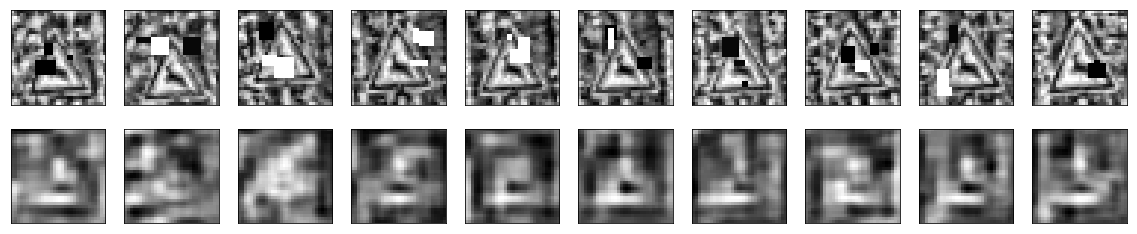

In [48]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train_noisy[i+100].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs_train[i+100].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)

input_shape=x_train[1].shape
                   
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(target_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


model.fit(decoded_imgs_train,target_train,
          epochs=20,
          validation_data=(x_test, target_test),
          callbacks=[early_stopping_monitor])

Train on 23100 samples, validate on 11970 samples
Epoch 1/20
23100/23100 [==============================] - 73s 3ms/step - loss: 0.4057 - acc: 0.8712 - val_loss: 0.6186 - val_acc: 0.7886
Epoch 2/20
23100/23100 [==============================] - 82s 4ms/step - loss: 0.2299 - acc: 0.9255 - val_loss: 0.5641 - val_acc: 0.8119
Epoch 3/20
23100/23100 [==============================] - 75s 3ms/step - loss: 0.2034 - acc: 0.9324 - val_loss: 0.6504 - val_acc: 0.7846
Epoch 4/20
23100/23100 [==============================] - 77s 3ms/step - loss: 0.1852 - acc: 0.9388 - val_loss: 0.6032 - val_acc: 0.7942
Epoch 5/20
23100/23100 [==============================] - 77s 3ms/step - loss: 0.1667 - acc: 0.9459 - val_loss: 0.8415 - val_acc: 0.7331


In [51]:
model.evaluate(autoencoder.predict(x_test_noisy),target_test)

11970/11970 [==============================] - 10s 844us/step


[0.5766466075093399, 0.8302422723475356]

In [52]:
model.evaluate(autoencoder.predict(x_test),target_test)

11970/11970 [==============================] - 10s 858us/step


[0.47896697977730895, 0.8593984962406015]

In [65]:
X_train = np.append(decoded_imgs_train,x_train,axis = 0)
Target_train = np.append(target_train,target_train,axis = 0)
X_test = np.append(decoded_imgs_test,x_test,axis = 0)
Target_test = np.append(target_test,target_test,axis = 0)

In [69]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=5)

input_shape=x_train[1].shape
                   
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(target_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


model.fit(X_train,Target_train,
          epochs=20,
          validation_data=(X_test, Target_test),
          callbacks=[early_stopping_monitor])

Train on 46200 samples, validate on 23940 samples
Epoch 1/20
46200/46200 [==============================] - 140s 3ms/step - loss: 0.2739 - acc: 0.9123 - val_loss: 0.4364 - val_acc: 0.8502
Epoch 2/20
46200/46200 [==============================] - 135s 3ms/step - loss: 0.1412 - acc: 0.9535 - val_loss: 0.3556 - val_acc: 0.8849
Epoch 3/20
46200/46200 [==============================] - 136s 3ms/step - loss: 0.1116 - acc: 0.9629 - val_loss: 0.3761 - val_acc: 0.8958
Epoch 4/20
46200/46200 [==============================] - 129s 3ms/step - loss: 0.0949 - acc: 0.9672 - val_loss: 0.4564 - val_acc: 0.8731
Epoch 5/20
46200/46200 [==============================] - 130s 3ms/step - loss: 0.0846 - acc: 0.9703 - val_loss: 0.5784 - val_acc: 0.8721
Epoch 6/20
46200/46200 [==============================] - 131s 3ms/step - loss: 0.0739 - acc: 0.9743 - val_loss: 0.4607 - val_acc: 0.8880
Epoch 7/20
46200/46200 [==============================] - 132s 3ms/step - loss: 0.0648 - acc: 0.9776 - val_loss: 0.4958 - 

In [68]:
model.evaluate(X_test,Target_test)

23940/23940 [==============================] - 18s 764us/step


[0.3649096120069098, 0.8930242272347535]